# Booster trainer
This notebook trains two different BDTs:
- Trained with conversion electrons as signal and DIOs as background
- Trained with conversion electrons as signal and cosmic rays as background

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

In [127]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

import uproot
import pickle
import booster
# import importlib
# importlib.reload(booster)

In [115]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [116]:
def from_root_to_pandas(filename):
    file = uproot.open(filename)
    trkananeg = file["TrkAnaNeg"]["trkana"]

    df = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
    df["is_triggered"] = (df["trigbits"].values & 0x208) > 0
    df["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                           if index>=0 else 0 
                                           for index, twstart in zip(df["bestcrv"], df["crvinfo__timeWindowStart"])]
    df["is_signal"] = (df["demcgen_gen"] == 43) | (df["demcgen_gen"] == 2)
    
    return df


df_mc = from_root_to_pandas("root_files/trkana-mc.root")
df_ce = from_root_to_pandas("root_files/ce.root")

In [122]:
dio_train, dio_test = train_test_split(df_mc, test_size=0.5, random_state=1990)
ce_train, ce_test = train_test_split(df_ce, test_size=0.5, random_state=1990)

samples = {'dio': (dio_train, dio_test),
           'ce': (ce_train, ce_test)}

XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Training Decay-in-orbit...
Validating...
area under the precision-recall curve: 0.998928
precision score: 0.989971
recall score: 0.980470
Training Cosmic ray...
Validating...
area under the precision-recall curve: 0.999955
precision score: 0.996947
recall score: 0.999036


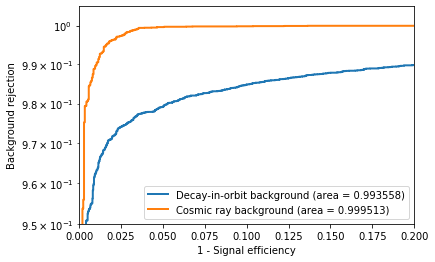

In [128]:
import importlib
importlib.reload(booster)

fig, ax = plt.subplots(1,1)

my_booster = booster.Booster(samples, booster.variables, random_state=1990)

for label, bkg_query in zip(booster.labels, booster.bkg_queries):
    preds = my_booster.train_booster(ax, bkg_query)
    
    with open('pickles/booster_%s.pickle' % label, 'wb') as booster_file:
        pickle.dump(preds, booster_file)

    variables = booster.variables.copy()
    variables.remove("is_signal")

    prediction = preds.predict(
        xgb.DMatrix(df[variables]),
        ntree_limit=preds.best_iteration)

ax.set_ylim(0.95, 1.005)
ax.set_yscale('log')
ax.set_xlim(0, 0.2)
leg = ax.legend()